### CH17 - AutoEncoder and GAN 
- AutoEncoder와 GAN은 unsupervised learning model
- AutoEncoder: 단순히 입력을 출력으로 복사하는 방법
- GAN: 신경망 두개로 구성
    - 생성자(generator): 훈련 데이터와 비슷하게 보이는 데이터를 생성
    - 판별자(discriminator): 가짜 데이터와 진짜 데이터를 구별
    




#### AutoEncoder
- Encoder: 입력을 내부 표현으로 변경
- Decoder:내부표현을 출력으로 변경

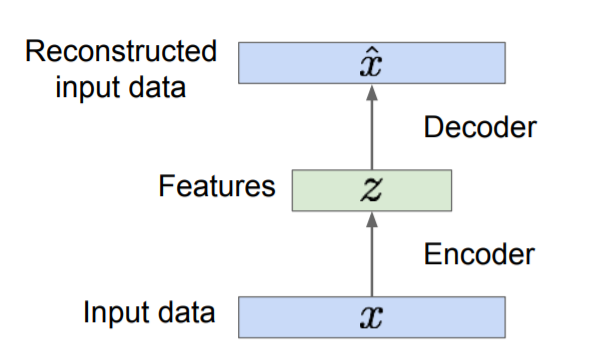

#### Set up

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

#### 17.3.1 적층 오토인코더
- 은닉층을 여러개 갖는 오토인코더
- 층을 더 추가하여 복잡한 코딩을 학습할 수 있다.
- 이때, 오토인코더가 너무 강력해지지 않도록 주의해야 한다.
- 가운데를 기준으로 대칭을 이루는 구조
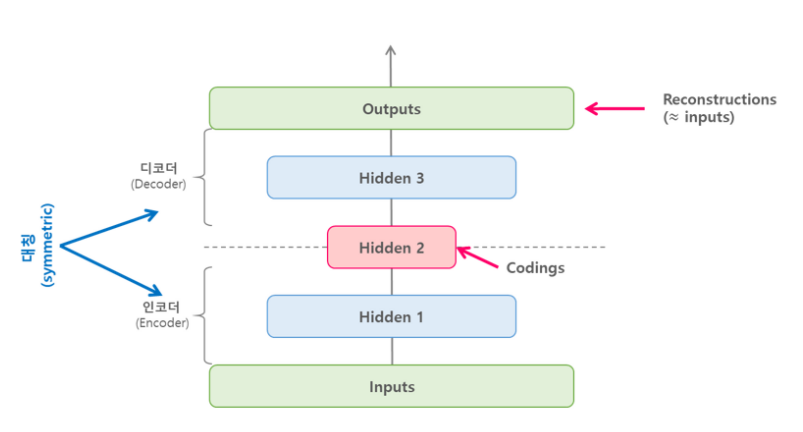



#### 17.3.1 적층 오토인코더 구현


In [ ]:
(X_train_full,y_train_full),(X_test,y_test)=keras.datasets.fashion_mnist.load_data()
X_train_full=X_train_full.astype(np.float32)/255
X_test=X_test.astype(np.float32)/255
X_train,X_valid=X_train_full[:-5000],X_train_full[-5000:]
y_train,y_valid=y_train_full[:-5000],y_train_full[-5000:]

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
def rounded_accuracy(y_true,y_pred):
  return keras.metrics.binary_accuracy(tf.round(y_true),tf.round(y_pred))

In [ ]:
from tensorflow.python.ops.gen_data_flow_ops import record_input_eager_fallback
tf.random.set_seed(42)
np.random.seed(42)

# encoder
stacked_encoder=keras.models.Sequential([
                                         keras.layers.Flatten(input_shape=[28,28]),
                                         keras.layers.Dense(100,activation='selu'),
                                         keras.layers.Dense(30,activation='selu')
])

# decoder
stacked_decoder=keras.models.Sequential([
                                         keras.layers.Dense(100,activation='selu',input_shape=[30]),
                                         keras.layers.Dense(28*28,activation='sigmoid'),
                                         keras.layers.Reshape([28,28])
])

stacked_ae=keras.models.Sequential([stacked_encoder,stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy',
                   optimizer=keras.optimizers.SGD(lr=1.5))
history=stacked_ae.fit(X_train,X_train,epochs=20,validation_data=(X_valid,X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
1719/1719 [==============================] - 7s 3ms/step - loss: 0.3381 - val_loss: 0.3164
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3056 - val_loss: 0.3021
Epoch 3/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2986 - val_loss: 0.2993
Epoch 4/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2948 - val_loss: 0.2938
Epoch 5/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2923 - val_loss: 0.2919
Epoch 6/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2904 - val_loss: 0.2913
Epoch 7/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2890 - val_loss: 0.2905
Epoch 8/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2877 - val_loss: 0.2950
Epoch 9/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2869 - val_loss: 0.2907
Epoch 10/20
1719/1719 [==============================] - 6s 3ms/step - loss: 0.285

In [ ]:
def show_reconstructions(model,images=X_valid,n_images=5):
    reconstructions=model.predict(images[:n_images])
    fig=plt.figure(figsize=(n_images*1.5,3))
    for image_index in range(n_images):
      plt.subplot(2,n_images,1+image_index)
      plot_image(images[image_index])
      plt.subplot(2,n_images,1+n_images+image_index)
      plot_image(reconstructions[image_index])

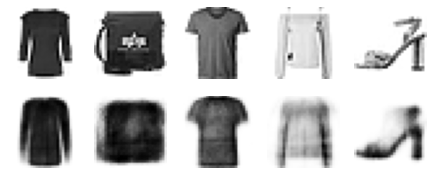

In [ ]:
show_reconstructions(stacked_ae)

#### 17.3.5 가중치 묶기
- 오토인코더가 완벽하게 대칭인때 디코더의 가중치와 인코더의 가중치를 묶는다.
- ex) 어떤 오토인코더가 N개의 층을 갖고 WL이 L번째 층의 가중치를 나타낼때 디코더의 가중치는 Wn-l+1=WL^T(L=1,2,.....,N/2)

In [ ]:
class DenseTranspose(keras.layers.Layer):
  def __init__(self,dense,activation=None,**kwargs):
    self.dense=dense
    self.activation=keras.activations.get(activation)
    super().__init__(**kwargs)
  
  def build(self,batch_input_shape):
    self.biases=self.add_weight(name='bias',initializer='zeros',
                                shape=[self.dense.input_shape[-1]])
    super().build(batch_input_shape)
  def call(self,inputs):
    z=tf.matmul(inputs,self.dense.weights[0],transpose_b=True) # transepose_b=True: 두번째 매개변수를 전치하는 것과 동일
    return self.activation(z+self.biases)

In [ ]:
# 디코더의 Dense층과 인코더의 Dense층을 묶기
dense_1=keras.layers.Dense(100,activation='selu')
dense_2=keras.layers.Dense(30,activation='selu')

tied_encoder=keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                      dense_1,
                                      dense_2])

tied_decoder=keras.models.Sequential([DenseTranspose(dense_2,activation='selu'),
                                      DenseTranspose(dense_1,activation='sigmoid'),
                                      keras.layers.Reshape([28,28])
                                      ])
tied_ae=keras.models.Sequential([tied_encoder,tied_decoder])

In [ ]:
tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.3282 - rounded_accuracy: 0.8945 - val_loss: 0.3084 - val_rounded_accuracy: 0.9082
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.2992 - rounded_accuracy: 0.9205 - val_loss: 0.2976 - val_rounded_accuracy: 0.9258
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2931 - rounded_accuracy: 0.9262 - val_loss: 0.3033 - val_rounded_accuracy: 0.9056
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2898 - rounded_accuracy: 0.9292 - val_loss: 0.2894 - val_rounded_accuracy: 0.9306
Epoch 5/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2875 - rounded_accuracy: 0.9314 - val_loss: 0.2883 - val_rounded_accuracy: 0.9304
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2859 - rounded_accuracy: 0.9328 - val_loss: 0.2871 - val_rounded_accuracy: 0.9334
Epoch 7/10
1719/1719 [==================

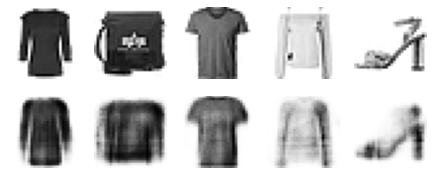

In [ ]:
show_reconstructions(tied_ae)
plt.show()

#### 적층 오토인코더를 사용한 비지도 사전훈련
- 기존의 네트워크에서 학습한 특성 감지 기능을 재사용
- 레이블되지 않은 대량의 데이터셋이 있을경우, 먼저 전체 데이터를 사용해 적층 인코더를 훈련
- 오토인코더의 하위층을 재사용 → 실제문제를 해결하기 위한 신경망을 만들고 레이블된 데이터를 사용해 훈련 가능

#### 적층 오토인코더를 사용한 비지도 사전훈련

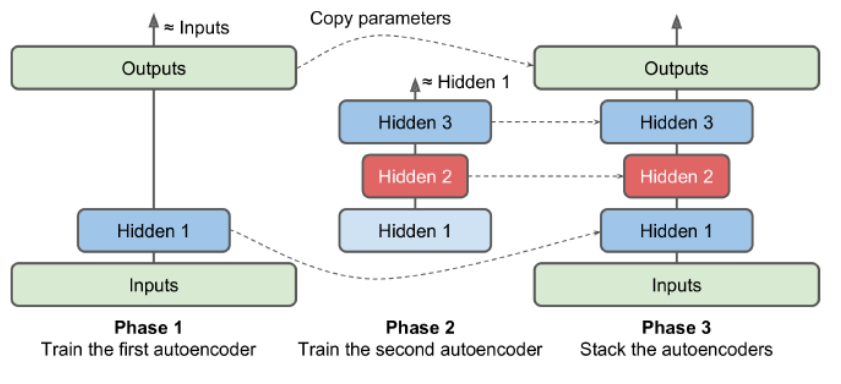

#### 17.7 희소 오토인코더

- 오토인코더가 좋은 특성을 추출하도록 만드는 희소성을 이용한 제약방법
- 손실함수에 적절한 항을 추가하여, 오토인코더가 코딩층(coding layer, 가운데 층)에서 활성화되는 뉴런수를 감소시키는 것
- Sparse Autoencoder를 만들기 위해서는 학습단계에서 코딩층의 실제 sparse정도를 측정해야 하는데, 전체 학습 배치에 대해 코딩층의 평균적인 활성화를 계산한다.

- 희소 손실 구하는 방법
   - 제곱 오차를 추가한다.
   - But, Sparse AutoEncoder에서는 아래 그래프처럼 MSE보다 더 경사가 급한, 쿨백 라이블러 발산(KL-divergence, Kullback- Leibler divergence)를 사용

(0.0, 1.0, 0.0, 0.95)

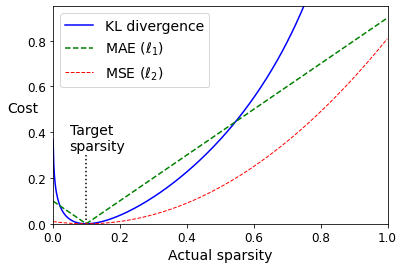

In [ ]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
